In [30]:
import cooler
import cooltools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap

In [55]:
data_dir = '../../data/outside/'
filename = 'GM12878.mcool'
resolution = 10_000 # No 20kb resolution available in this file
start_idx = 220_000
region_length = 1_300_000

In [56]:
region = ('chrX', start_idx, start_idx + region_length)
clr = cooler.Cooler(f'{data_dir}{filename}::resolutions/{resolution}')
norm = LogNorm(vmax=1)

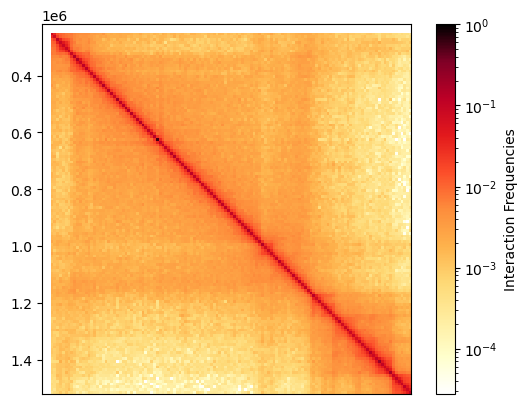

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111) 

im = ax.matshow(
    clr.matrix().fetch(region),
    norm=norm,
    cmap='fall',
    extent=(region[1], region[2], region[2], region[1])
);
ax.xaxis.set_visible(False)

cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

In [76]:
# From https://stackoverflow.com/questions/57081727/load-pickle-file-obtained-from-gpu-to-cpu
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

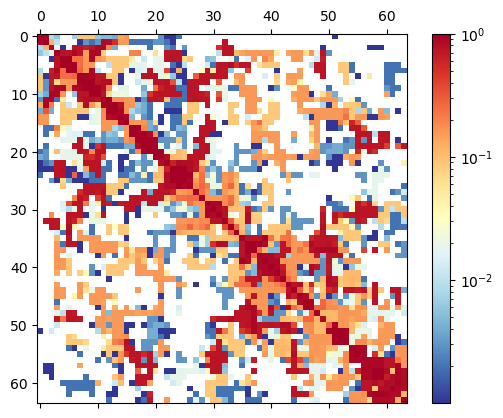

In [93]:
import sys
sys.path.insert(1,'../data_utils_v2/')
from Sample import Sample
import torch

import pickle
sample = CPU_Unpickler(open('../diffusion/results_large/generated_hic_map.pkl','rb')).load()['sample'];

In [133]:
def fetch_at_20kb(clr,region,remove_diagonal=True):
    mat = clr.matrix().fetch(region)
    mat = torch.from_numpy(mat).reshape(1,1,*mat.shape)
    mat = torch.nn.functional.avg_pool2d(mat,kernel_size=2)
    if remove_diagonal: 
        b,c,im,_ = mat.shape
        mat1 = torch.empty(b,c,im-1,im-1,device=mat.device,dtype=mat.dtype)
        i,j = torch.triu_indices(im,im,1) 
        mat1[...,i,j-1] = mat[...,i,j] 
        mat1[...,j-1,i] = mat[...,j,i]
        mat = mat1 
    return mat
    

In [142]:
z

tensor([[0.8430, 0.0190, 0.0010,  ..., 0.8180, 0.1130, 1.0000],
        [0.0187, 0.0102, 0.0066,  ..., 0.0088, 0.0150, 0.0293]])

In [134]:
def get_HiC(sample):
    return sample.get_scHiC().mean(0).reshape(sample.batch_seg_len,sample.batch_seg_len)

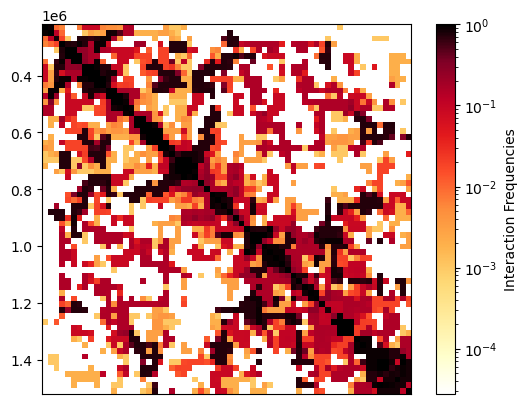

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111) 

im = ax.matshow(
    get_HiC(sample).cpu().numpy(),
    norm=norm,
    cmap='fall',
    extent=(region[1], region[2], region[2], region[1])
);
ax.xaxis.set_visible(False)

cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

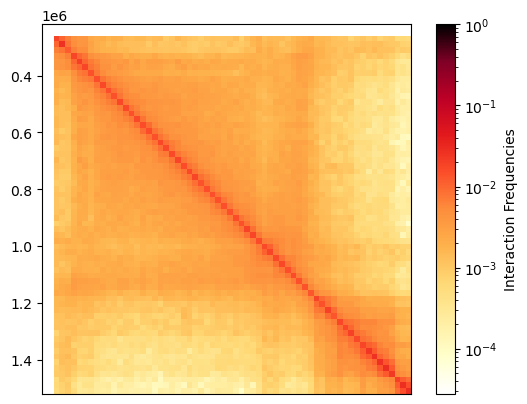

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111) 

im = ax.matshow(
    fetch_at_20kb(clr,region).squeeze(),
    norm=norm,
    cmap='fall',
    extent=(region[1], region[2], region[2], region[1])
);
ax.xaxis.set_visible(False)

cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

In [143]:
x = get_HiC(sample).flatten()
#y = torch.from_numpy(clr.matrix().fetch(region)).flatten().to(x.device,x.dtype)
y = fetch_at_20kb(clr,region).flatten().to(x.device,x.dtype)
z = torch.stack([x,y],dim=0) 
z = z[:,z.isfinite().all(0)]

torch.corrcoef(z)

tensor([[1.0000, 0.4887],
        [0.4887, 1.0000]])

In [104]:
def plot_hist(sample,i,j):

    # Reference (all interactions with same genomic separation) 
    ii,jj = sample.triu_indices
    idx = jj-ii == i-j 
    plt.hist(
        
    )
    
    # Data at specified location
    plt.hist(
        torch.cat([sample.batch[...,i,j],sample.batch[...,j,i]],dim=0).flatten().cpu().numpy(),
        alpha=0.5
    )
    

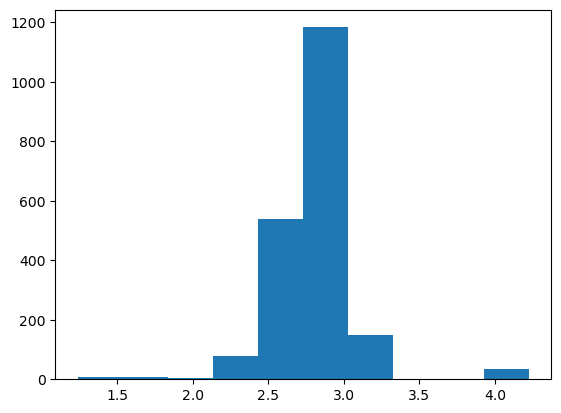

In [105]:
plot_hist(sample,0,10)

In [ ]:
from IPython.display import Image
Image(filename='../diffusion/results_large/hic_map.png')

In [65]:
cbar.get_label()

AttributeError: 'Colorbar' object has no attribute 'get_label'

In [ ]:
def plot_hic

In [3]:
import cooltools

ModuleNotFoundError: No module named 'cooltools'

## Analyze data obtained from overnight generations

In [13]:
# Standard libraries
import os
import sys
import pickle
import torch 
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap

# Hi-C data manipulation
from cooler import Cooler
import cooltools

# Custom classes
sys.path.insert(1,'../data_utils_v2/')
from Sample import Sample

In [14]:
chrom = 'X'

In [15]:
def fetch_at_20kb(clr,region,remove_diagonal=True):
    mat = clr.matrix().fetch(region)
    mat = torch.from_numpy(mat).reshape(1,1,*mat.shape)
    mat = torch.nn.functional.avg_pool2d(mat,kernel_size=2)
    if remove_diagonal: 
        b,c,im,_ = mat.shape
        mat1 = torch.empty(b,c,im-1,im-1,device=mat.device,dtype=mat.dtype)
        i,j = torch.triu_indices(im,im,1) 
        mat1[...,i,j-1] = mat[...,i,j] 
        mat1[...,j-1,i] = mat[...,j,i]
        mat = mat1 
    return mat
    

In [25]:
def load_sample(region,cond_scale,rescaled_phi,milestone,chrom,small_model=True,root_dir='../diffusion/'): 

    fp = root_dir 
    if fp[-1] != '/':
        fp+= '/'
    
    if small_model:
        fp+= 'sampling_small/'
    else:
        fp+= 'sampling_large/'
    
    return pd.read_pickle(fp+f'sample_{region}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl')
    

In [82]:
def get_HiC(sample):
    return sample.get_scHiC().mean(0).reshape(sample.batch_seg_len,sample.batch_seg_len)

In [ ]:
def fetch_at_20kb(clr,region,remove_diagonal=True):
    mat = clr.matrix().fetch(region)
    mat = torch.from_numpy(mat).reshape(1,1,*mat.shape)
    mat = torch.nn.functional.avg_pool2d(mat,kernel_size=2)
    if remove_diagonal: 
        b,c,im,_ = mat.shape
        mat1 = torch.empty(b,c,im-1,im-1,device=mat.device,dtype=mat.dtype)
        i,j = torch.triu_indices(im,im,1) 
        mat1[...,i,j-1] = mat[...,i,j] 
        mat1[...,j-1,i] = mat[...,j,i]
        mat = mat1 
    return mat
    

In [143]:
data_dir = '../../data/outside/'
filename = 'GM12878.mcool'
resolution = 10_000 # No 20kb resolution available in this file
start_idx = 220_000
region_length = 1_300_000

region = (f'chr{chrom}', start_idx, start_idx + region_length)
clr = Cooler(f'{data_dir}{filename}::resolutions/{resolution}')
norm = LogNorm(vmax=1)

In [132]:
milestone = 69#38 
chrom=22
samples = []
index = []
for region_ in range(0,1000,50):
    for cond_scale in [float(k) for k in range(1,11)]:
        for rescaled_phi in [k/10 for k in range(1,11)]:

            try: 
                samples.append(
                    load_sample(region_,cond_scale,rescaled_phi,milestone,chrom)
                )
            except:
                continue

            index.append((region_,cond_scale,rescaled_phi))
            
samples = pd.DataFrame(
    data=samples,
    index=pd.MultiIndex.from_tuples(index)
)

In [133]:
samples.iloc[0,0]

In [134]:
region = (f'chr{chrom}',16980000,16980000+1300000)

In [135]:
true_hic_map = fetch_at_20kb(clr,region).squeeze()

In [136]:
i,j = torch.triu_indices(*true_hic_map.shape,0)
true_triu = true_hic_map[i,j] 
idx = true_triu.isfinite()
true_triu = true_triu[idx] 
best = (-1,-1)
for i in range(len(samples)):
    region_,cond_scale,rescaled_phi = samples.index[i]
    if region_ != 0: 
        continue
    sample = samples.iloc[i,0]

    hic_map = get_HiC(sample)

    triu = hic_map[i,j][idx] 

    corr = torch.stack([true_triu,triu],dim=0)
    corr = torch.corrcoef(corr)[0,1]
    
    if corr > best[1]: 
        best = (i,corr) 


In [140]:
best

(0, tensor(0.2064, dtype=torch.float64))

In [137]:
samples.index[best[0]]

(0, 1.0, 0.5)

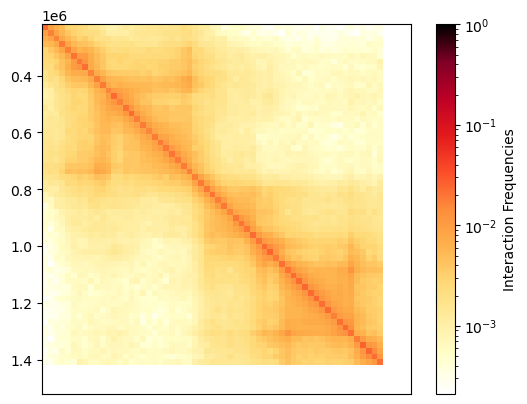

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111) 

im = ax.matshow(
    true_hic_map,
    norm=norm,
    cmap='fall',
    extent=(region[1], region[2], region[2], region[1])
);
ax.xaxis.set_visible(False)

cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

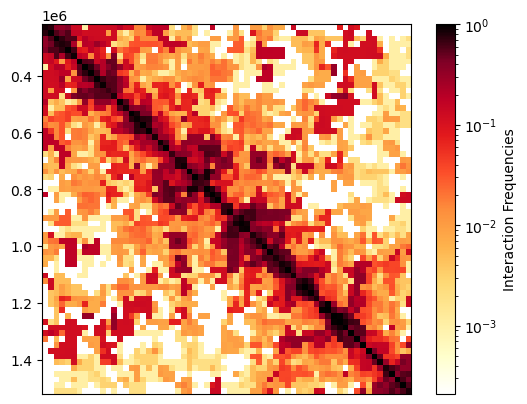

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111) 

im = ax.matshow(
    get_HiC(samples.iloc[best[0],0]).cpu().numpy(),
    norm=norm,
    cmap='fall',
    extent=(region[1], region[2], region[2], region[1])
);
ax.xaxis.set_visible(False)

cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

In [ ]:
sample.unnormalize_();
plt.matshow(sample.batch[0,0,...].cpu().numpy())
plt.colorbar()

(array([ 2.,  3.,  5.,  2., 24., 20.,  4.,  3.,  0.,  1.]),
 array([0.22859717, 0.44088919, 0.65318121, 0.86547323, 1.07776525,
        1.29005727, 1.50234929, 1.7146413 , 1.92693332, 2.13922534,
        2.35151736]),
 <BarContainer object of 10 artists>)

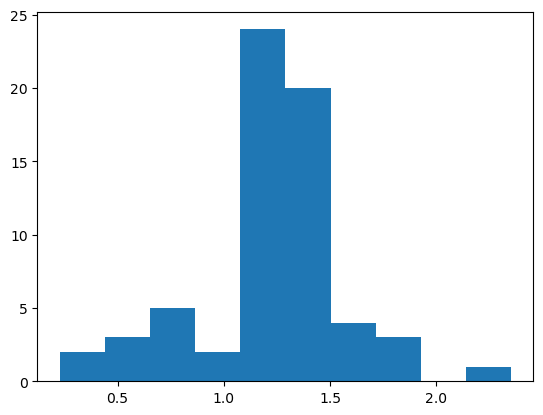

In [81]:
plt.hist(sample.batch[10,0,...].diag().numpy())